In [223]:
## load in relevant packages
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [206]:
##===================================================================================
## read in data

## winter
## collapsed over time
#dta = pd.read_csv("../data/kcl_london_model_data_winter_collapsed.csv", sep=',') 
## aggregated over time
#dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')

## not winter
## collapsed over time
#dta = pd.read_csv("../data/kcl_london_model_data_nowinter_collapsed.csv", sep=',')
## aggregated over time
#dta = pd.read_csv("../data/kcl_london_model_data_nowinter_agg_time.csv", sep=',')

## monthly data (2000-2019)
dta = pd.read_csv("../data/kcl_london_model_data_monthly.csv", sep=',')
## subset to only January
dta = dta[dta['month']==1]
##===================================================================================

In [176]:
## preview data
print(dta.head())
print(dta.shape)

## divide into features and variable
X = dta[['latitude', 'longitude']].values  
y = dta.loc[:,'nox'].values  

print(X.shape)
print(y.shape)


## print previews
print(y[0:10])
print(X[1:10,:])

           nox  month  year                                        site code  \
0    83.640993      1  2000  - National Physical Laboratory, Teddington  TD0   
12  109.622354      1  2001  - National Physical Laboratory, Teddington  TD0   
24   46.070849      1  2002  - National Physical Laboratory, Teddington  TD0   
36   47.500380      1  2003  - National Physical Laboratory, Teddington  TD0   
48   29.871254      1  2004  - National Physical Laboratory, Teddington  TD0   

     latitude  longitude site_type  
0   51.424304  -0.345715  Suburban  
12  51.424304  -0.345715  Suburban  
24  51.424304  -0.345715  Suburban  
36  51.424304  -0.345715  Suburban  
48  51.424304  -0.345715  Suburban  
(1760, 8)
(1760, 2)
(1760,)
[ 83.64099315 109.62235366  46.07084892  47.50038008  29.87125417
  33.0858614   63.38430283  29.53777391  34.556675    76.21732525]
[[51.42430434 -0.34571458]
 [51.42430434 -0.34571458]
 [51.42430434 -0.34571458]
 [51.42430434 -0.34571458]
 [51.42430434 -0.34571458]
 

In [207]:
## create validation dataset (no test set since using CV)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0) 

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1320, 2)
(1320,)
(440, 2)
(440,)


In [208]:
#y_train = normalize(y_train[:,np.newaxis], axis=0).ravel()
#y_val = normalize(y_val[:,np.newaxis], axis=0).ravel()

## should I standardize X-values??
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()  
X_train = feature_scaler.fit_transform(X_train)  
X_val = feature_scaler.transform(X_val)  
print(X_train[1:5,:])
print(X_val[1:5,:])
print(X_val.shape)

[[ 0.36880612 -0.20618592]
 [-0.7480859   1.22415478]
 [ 0.94044196  1.21923906]
 [ 2.32443242  0.35495435]]
[[-0.19926662  1.37867316]
 [-2.19048959  0.02856202]
 [ 2.70130558  0.6353207 ]
 [-0.55473617  0.67301546]]
(440, 2)


In [209]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_val_score

In [210]:
kernel = RBF(length_scale=1)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1, normalize_y=True, n_restarts_optimizer=5)
all_accuracies = cross_val_score(estimator=gp, X=X_train, y=y_train, cv=5, scoring='r2').mean()
print(all_accuracies)
## winter data
## sigma = 1000, alpha=1
## 0.8037412498178955
## sigma = 1, alpha=1
## 0.8055139240920436
## sigma=1, alpha = 100
## 0.14285243700525588
## sigma=10, alpha=100
## 0.14285243655664298

KeyboardInterrupt: 

In [182]:
## search for best hyperparameters: sigma
all_accuracies_mean = []
all_accuracies_std = []
sigmas = np.arange(start=0.1, stop=4.5, step=0.5)
for sigma in sigmas:
    kernel = RBF(length_scale=sigma)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1, normalize_y=True, n_restarts_optimizer=5)
    all_accuracies = cross_val_score(estimator=gp, X=X_train, y=y_train, cv=5, scoring='r2')
    all_accuracies_mean.append(all_accuracies.mean())
    all_accuracies_std.append(all_accuracies.std())
print(sigmas)
print(all_accuracies_mean)
print(all_accuracies_std)

[0.1 0.6 1.1 1.6 2.1 2.6 3.1 3.6 4.1]
[0.6940555954269788, 0.6898196537953746, 0.6944528937441867, 0.6927158396094354, 0.6869081608452217, 0.6948114695097887, 0.6916358500826731, 0.6940555331532028, 0.6935025478168034]
[0.041070172797740855, 0.03853552061021931, 0.03991437553850036, 0.036747918237862755, 0.03600136812218896, 0.041650574475035174, 0.03667360305962867, 0.041070143987732774, 0.039550087613067345]


In [193]:
## function to select the best parameter
def best_parameter (mean_acc, param_list):
    ## take sd of all accuracies, if small, then take the median sigma
    acc_sd = np.std(mean_acc)
    if acc_sd < 0.005:
        best_param = np.median(param_list)
    else:
        ## pick the sigma with the highest R^2
        best_param = param_list[np.argmax(mean_acc)]
    
        ## if large sd and tie, default to larger sigma (more variance)
        ## or could select the default value (1)
        #best_param = 1

    return(best_param)

In [ ]:
## find best parameter for sigma
best_sigma = best_parameter(all_accuracies_mean, sigmas)
print(best_sigma)

In [192]:
## search for best hyperparameters: alpha
all_accuracies_al_mean = []
all_accuracies_al_std = []
alphas = np.arange(start=0.1, stop=1.1, step=0.1)
for alpha in alphas:
    kernel = RBF(length_scale=best_sigma)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, normalize_y=True, n_restarts_optimizer=5)
    all_accuracies_al = cross_val_score(estimator=gp, X=X_train, y=y_train, cv=5, scoring='r2')
    all_accuracies_al_mean.append(all_accuracies_al.mean())
    all_accuracies_al_std.append(all_accuracies_al.std())
print(alphas)
print(all_accuracies_al_mean)
print(all_accuracies_al_std)

/usr/local/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00258629]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.6957024930138745, 0.6983816273173872, 0.6966645133376341, 0.6961344911270416, 0.7013347955295811, 0.6970937787477813, 0.6973263687067441, 0.6993222685594347, 0.6912880362891096, 0.6944528912161706]
[0.04637629457398394, 0.04476265843662869, 0.041593614713341526, 0.03988164055642415, 0.04202737554157689, 0.03970990177195565, 0.039605740143601985, 0.03893157207330941, 0.03640099748881205, 0.03991439579356878]


In [197]:
## select the best alpha
best_alpha = best_parameter(all_accuracies_al_mean, alphas)
print(best_alpha)

0.55


In [231]:
## now train model with best parameters
kernel = RBF(length_scale=best_sigma)
gp = GaussianProcessRegressor(kernel=kernel, alpha=best_alpha, normalize_y=True, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.55, copy_X_train=True,
             kernel=RBF(length_scale=2.1), n_restarts_optimizer=5,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [234]:
#X_val_adj = np.atleast_2d(X_val).T
y_pred, sigma = gp.predict(X_val, return_std=True)
from sklearn.metrics import r2_score
print(r2_score(y_val, y_pred))

0.7080998324268536

In [233]:
print(y_pred)

[190.68215268 105.64176306 116.34305996  83.02721028 189.45692716
 129.83800199 228.60979971  87.78189773 118.73093513 140.0984143
 107.20555774 166.44570346 135.41220204 138.88123894 333.74806194
 298.61365436 258.22927389 129.83800199 270.23434438  72.05086744
 110.54121403  81.30573504  59.90346403 330.70636115  87.95558279
 330.70636115 155.87754634  75.12670635 364.59120566  67.27063508
 330.70636115 156.28040314 152.75570843  90.16559155 187.7260435
 129.79484662 181.23032505  76.32174093  79.44841385 233.5065867
 158.41398914 112.0098779   84.00888673 161.57119804 114.01231873
  76.2932723  119.51900116 138.12681143 181.23032505  74.75024999
  94.62953847 111.7088209  258.22927389  87.95558279 200.27577366
 155.87754634 111.7088209  152.75570843 183.25521371 276.32528924
 141.09682596  92.92525903  80.80156457  63.92309273 298.61365436
  84.23910612 118.84797847 140.86012652 118.73093513 166.44570346
 159.16191162  79.17570876 115.72836737  91.95681748 124.23230611
  80.45717835

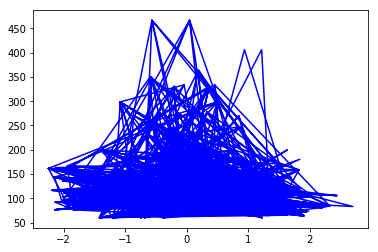

In [235]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
#plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(X_val, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
#         np.concatenate([y_pred - 1.9600 * sigma,
#                        (y_pred + 1.9600 * sigma)[::-1]]),
#         alpha=.5, fc='b', ec='None', label='95% confidence interval')
#plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
#plt.legend(loc='upper left')

plt.show()

In [225]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [226]:
print(y_pred)

[ 6.31562726e-02  6.82705965e-02  7.34471199e-02  7.86858926e-02
  8.39869546e-02  8.93503356e-02  9.47760555e-02  1.00264123e-01
  1.05814538e-01  1.11427288e-01  1.17102350e-01  1.22839692e-01
  1.28639268e-01  1.34501024e-01  1.40424892e-01  1.46410794e-01
  1.52458641e-01  1.58568331e-01  1.64739750e-01  1.70972775e-01
  1.77267267e-01  1.83623078e-01  1.90040046e-01  1.96517997e-01
  2.03056745e-01  2.09656090e-01  2.16315820e-01  2.23035712e-01
  2.29815526e-01  2.36655013e-01  2.43553907e-01  2.50511932e-01
  2.57528797e-01  2.64604197e-01  2.71737814e-01  2.78929316e-01
  2.86178357e-01  2.93484578e-01  3.00847603e-01  3.08267046e-01
  3.15742503e-01  3.23273558e-01  3.30859779e-01  3.38500721e-01
  3.46195922e-01  3.53944906e-01  3.61747185e-01  3.69602251e-01
  3.77509586e-01  3.85468652e-01  3.93478900e-01  4.01539764e-01
  4.09650661e-01  4.17810995e-01  4.26020154e-01  4.34277509e-01
  4.42582417e-01  4.50934218e-01  4.59332237e-01  4.67775783e-01
  4.76264149e-01  4.84796